In [44]:
# %%writefile run.py

import numpy as np
import brian2
import importlib

importlib.reload(connectivity)
importlib.reload(local_circuit)
importlib.reload(delays)
importlib.reload(model)

# Set up simulation parameters
dt = 0.5 * brian2.ms  # timestep
trial_length = 2000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)
stim_on      = 0.5 * brian2.second #s
stim_off     = 0.8 * brian2.second #s
# print(num_iterations)

surf_file = '../fsaverage4/lh.pial'
cort_file = '../fsaverage4/lh.cortex.label'

surface_connectivity = connectivity.get_surface_connectivity(surf_file, cort_file)
num_nodes = len(surface_connectivity)

tract_connectivity = connectivity.get_longdistance_connectivity(surf_file, cort_file, 
                                                                '../conn_data/average_sc.pconn.nii', 
                                                                '../conn_data/Glasser_NetworkPartition_v9.fsa4.L.label.gii')

tract_delays, max_delay, S_tract_delay = delays.get_delays(surf_file, cort_file)

parameters = local_circuit.initialize_parameters(num_nodes, 
                                                 g_E_self=0.39, g_IE=0.33, g_I_self=-0.05, g_EI=-0.4)

I_noise, noise_rhs, I_longRange_NMDA, I_midRange_NMDA,I_midRange_GABA, S_NMDA, I_local_NMDA, J_NMDA, J_GABA, S_GABA, I_local_GABA, I_total, I_0, R, num_pops = local_circuit.initiatize_local(parameters, num_nodes, num_iterations, dt)

V1_index     = model.get_stim('../fsaverage4/lh.aparc.a2009s.annot', 'S_calcarine', cort_file)
I_ext        = np.zeros((num_iterations, num_nodes, num_pops)) * brian2.amp
I_ext[int(stim_on/dt):int(stim_off/dt),V1_index,0] = parameters['stim_strength']

################################
########## Run Model: ##########
################################

for i_t in range(1,num_iterations):

    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]

    # long range NMDA (along white matter tracts) with variable delays
    #x = parameters['g_E_longRange'] * np.sum(tract_connectivity * S_tract_delay, axis=1)
    #I_longRange_NMDA[i_t-1,:,0] = x
    #I_longRange_NMDA[i_t-1,:,1] = x

    # mid range NMDA (along surface), with a 6 timestep delay
    #I_midRange_NMDA[i_t-1,:,:] = parameters['g_E_midRange'] * surface_connectivity.dot(S_NMDA[i_t - 2,:,:])
    #I_midRange_GABA[i_t-1,:,:] = parameters['g_I_midRange'] * surface_connectivity.dot(S_GABA[i_t - 7,:,:])    

    # local NMDA
    I_local_NMDA[i_t-1,:,:] = J_NMDA.dot(S_NMDA[i_t-1,:,:].T).T

    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:,:] = J_GABA.dot(S_GABA[i_t-1,:,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background, external currents & noise & longRange
    I_total[i_t-1,:,:] = I_local_NMDA[i_t-1,:,:] +  I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise# + I_midRange_NMDA[i_t-1,:,:]# + I_midRange_GABA[i_t-1,:,:] #+ 
    # I_longRange_NMDA[i_t-1,:,:]

    # Update the firing rates of the excitatory population
    R[i_t,:,0] = R[i_t-1,:,0] + dt * local_circuit.current_to_frequency(I_total[i_t-1,:,0],'E',parameters) / parameters['tau_rates'] - dt * R[i_t-1,:,0] / parameters['tau_rates']

    # Update the firing rates of the inhibitory population.
    R[i_t,:,1] = R[i_t-1,:,1] + dt*local_circuit.current_to_frequency(I_total[i_t-1,:,1],'I',parameters) / parameters['tau_rates'] - dt*R[i_t-1,:,1]/parameters['tau_rates']

    # Update the NMDA synapses
    S_NMDA[i_t,:,0] = S_NMDA[i_t-1,:,0] + dt*local_circuit.NMDA_deriv(S_NMDA[i_t-1,:,0],R[i_t,:,0],parameters)

    # S_tract_delay = S_NMDA[i_t-tract_delays,:,0]

    # Update the GABA synapses
    S_GABA[i_t,:,1] = S_GABA[i_t-1,:,1] + dt*local_circuit.GABA_deriv(S_GABA[i_t-1,:,1],R[i_t,:,1],parameters)

    #print(i_t)

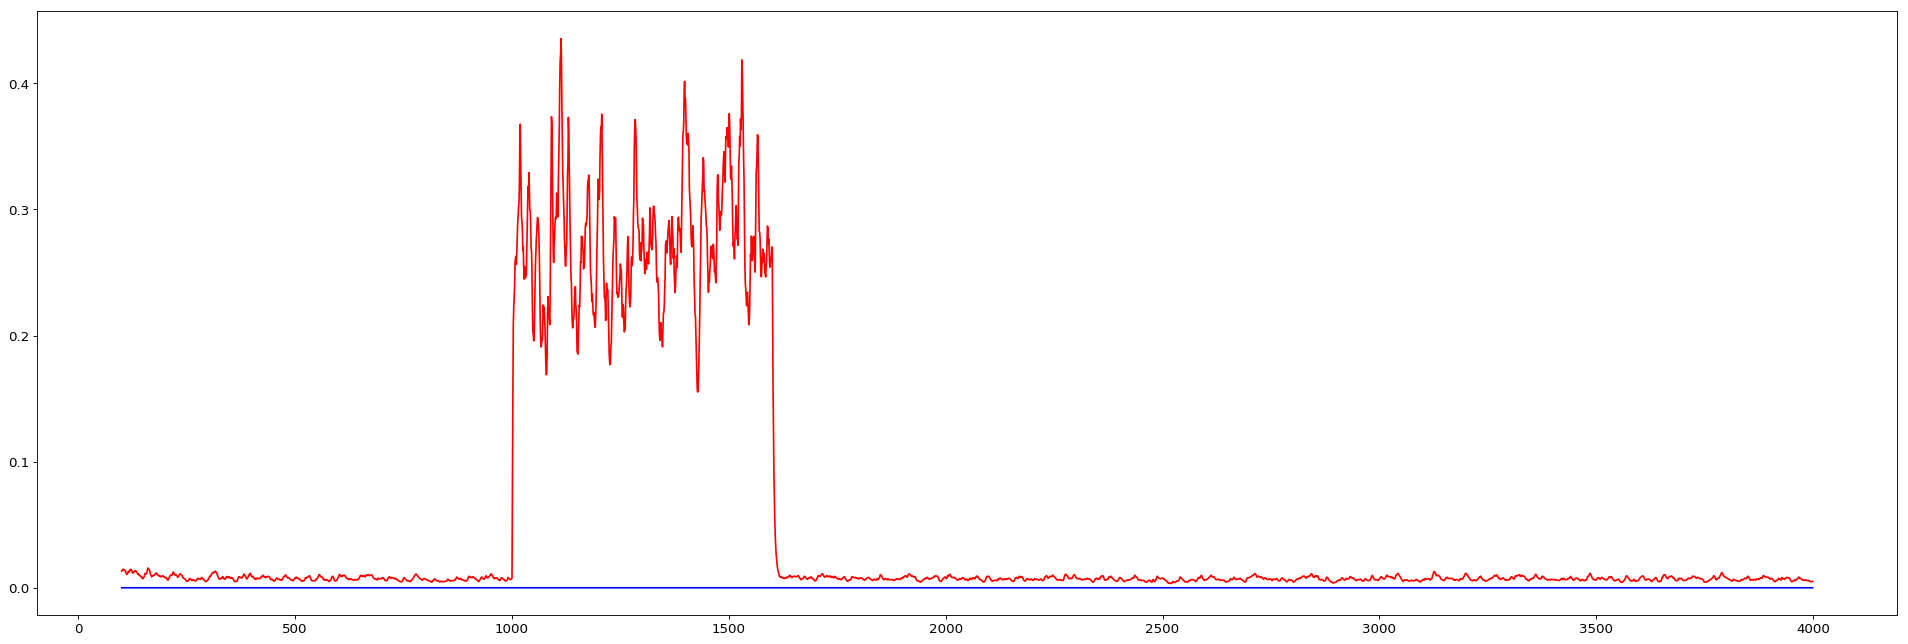

In [45]:
# To check response to stimulus

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,10), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
start_time = 0.0
end_time = trial_length #2 #seconds
i = V1_index[1]
i = 30
#ax = plt.subplot(10, 10, i)    

# Plot E population rates
plt.plot(range(len(R[:,i,0]))[100::],R[100::,i,0],color='r')
# Plot I population rates
plt.plot(range(len(R[:,i,1]))[100::],R[100::,i,1],color='b')

# Plot the stimulation time
#plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

# place text above the stimulation line
#axes = plt.gca()
#axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

#plt.legend(['E','I'])
#plt.xlabel('time (s)')
#plt.ylabel('firing rate (Hz)')
#plt.ylim(0, 80) 

plt.show()

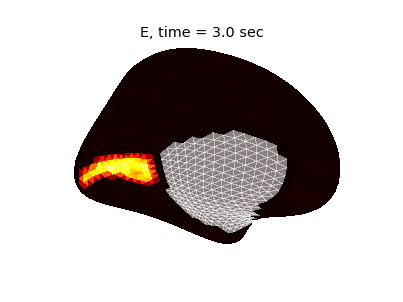

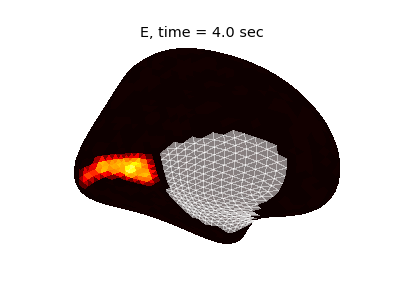

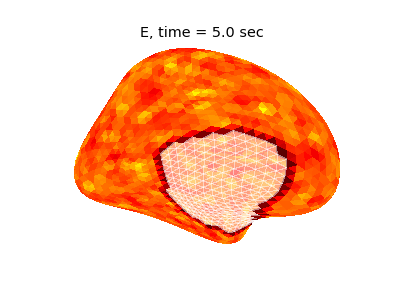

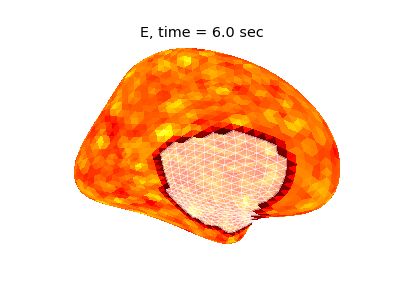

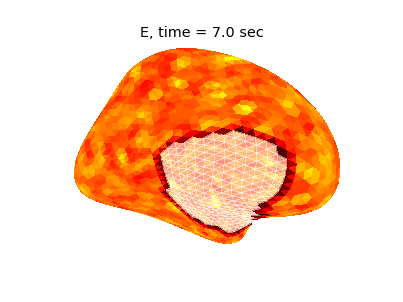

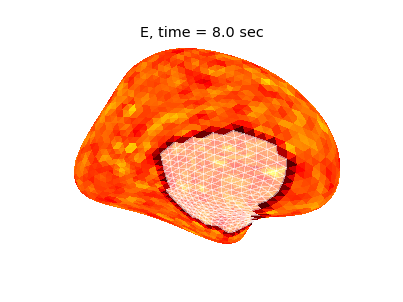

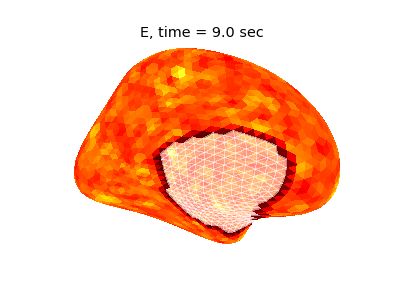

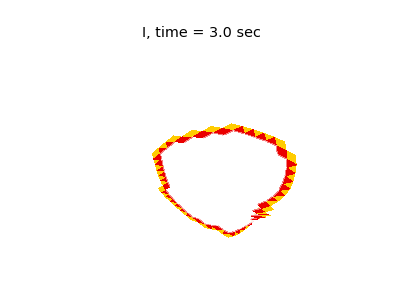

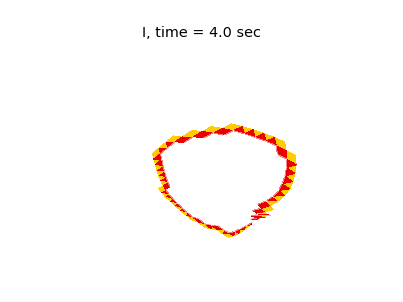

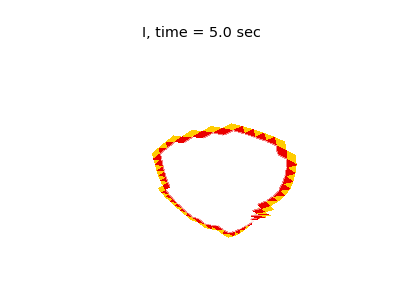

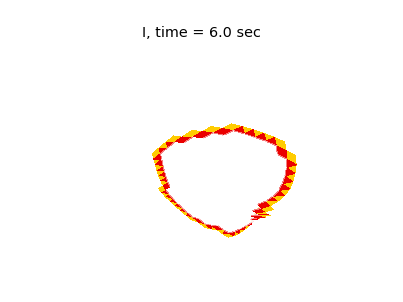

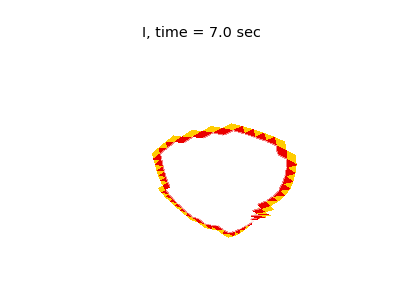

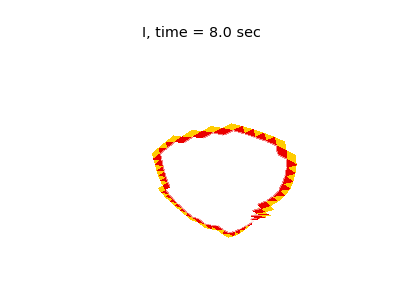

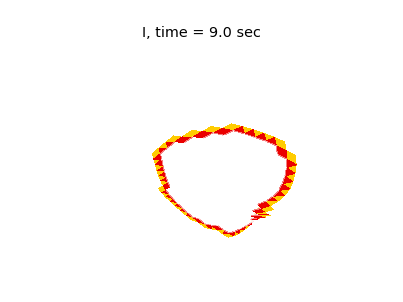

In [30]:
import nilearn 
from nilearn import plotting
import surfdist
import nibabel as nib

surf1 = nib.freesurfer.read_geometry('../fsaverage4/lh.pial')
cortex = np.sort(nib.freesurfer.read_label(cort_file))
    
# plot E:
tot = range(0,10)
for i in tot[3:]:
    d = surfdist.utils.recort(R[np.int(i*np.shape(R)[0]/len(tot)),:,0], surf1, cortex)
    plotting.plot_surf_stat_map('../fsaverage4/lh.inflated', d,
                                title=('E, time = %.1f sec' % i),
                                colorbar = False, view = 'medial'
                               )
# plot E:
tot = range(0,10)
for i in tot[3:]:
    d = surfdist.utils.recort(R[np.int(i*np.shape(R)[0]/len(tot)),:,1], surf1, cortex)
    plotting.plot_surf_stat_map('../fsaverage4/lh.inflated', d,                                
                                title=('I, time = %.1f sec' % i),
                                colorbar = False, view = 'medial'
                               )
